# Neural Networks Project
### Reimplementation of SemiTime

Course: Master in Artificial Intelligence and Robotics 2022-2023

Student: Spagnoli Valerio 1887715

Paper: **Semi-supervised time series classification by temporal relation prediction** (https://haoyfan.github.io/papers/SemiTime_ICASSP2021.pdf)


### Descriprion of SemiTime

#### Main Idea

This project is based on the paper "Semi-supervised time series classification by temporal relation prediction", which describes a novel approach for time series classification.
In this work the authors have proposed a method of semi-supervised time series classification architecture (termed as **SemiTime**) by gaining from the structure of unlabeled data in a self-supervised manner. 

The main idea of SemiTime is to use the labelled data of dataset for a classic supervised classification, and unlabelled data of dataset for a self-superviesed temporal relation classification. \
The temporal relation classification is used to help the model in features extracting phase.

#### Model
There are two models:  
- backbone encoder $ f_{\theta} $ + classification head $ h_{\mu} $
- backbone encoder $ f_{\theta} $ + relation head $ h_{\phi} $

The backbone encoder is the same for both of models, and is a 4-layer 1D convolutional neural network with ReLU activation function and batch normalization.

The classification head is linear layer with output = number of classes of dataset.

The relation head is a two layer fully connected networks with 256 hidden neurons.

**Supervised classification of classes**:

The first model perform a supervised classification of classes: given the labelled dataset $ \mathcal{D}_L = \{(\bold{t}_i, y_i)\}_{i=0}^M $, the backbone encoder $ f_{\theta} $ takes the time series as input to extract the feature embedding $ \mathcal{z}_i = f_{\theta}(\bold{t}_i) $, and then the classification head $ h_{\mu} $ perfoms the multiclass classification. \
For this part is used the Cross Entropy loss.

**Self-supervised classification of temporal relation**:

The second model perform a self-supervised classification of temporal relation between two segments. \
Given two segments, if the second is the future segmens of the first, they are in positive relation (labelled with 1), otherwise they are in negative relation (labelled with 0). \
So, given the unlabelled dataset  $ \mathcal{D}_U = \{(\bold{t}_i)\}_{i=0}^N $, each time series is split in two parts:
- the first part denotes the past segments,
- the second part denotes the future segmens.


For each segment in $ \mathcal{D}_U $ are created 2 segments (both of them split in 2 parts):
- the first is composed by the past and future parts of the same segmets, i.e. $ \bold{s}_i $ and $ \bold{s}_i^+ $ , and represents the positive relation (label = 1);
- the second is composed by the same past segment of the first one, i.e. $ \bold{s}_i $, but with a different future segment taken form another sample in $ \mathcal{D}_U $, i.e. $ \bold{s}_j^- $. This segment represents the negative relation (label = 0);

The backbone encoder takes for each segment $ \bold{s}_i $, $ \bold{s}_i^+ $ and $ \bold{s}_i^- $ to extract the features embedding $ \mathcal{z}_i = f_{\theta} (\bold{s}_i) $, $ \mathcal{z}_i^+ = f_{\theta} (\bold{s}_i^+) $ and $ \mathcal{z}_i^- = f_{\theta} (\bold{s}_i)^- $, and then the relation head $ h_{\phi} $ perform temporal relation prediction between segments (binary classification problem):
- $ h_{\phi} = ([\mathcal{z}_i, \mathcal{z}_i^+ ])$ for positive relation;
- $ h_{\phi} = ([\mathcal{z}_i, \mathcal{z}_i^- ])$ for negative relation;
For this part is used the Binary Cross Entropy loss

Note: $[\cdot, \cdot ]$ is the concatenation operation.


|Schematic illustration of semi-supervised techniques described| SemiTime architecture|
|--------|--------|
|  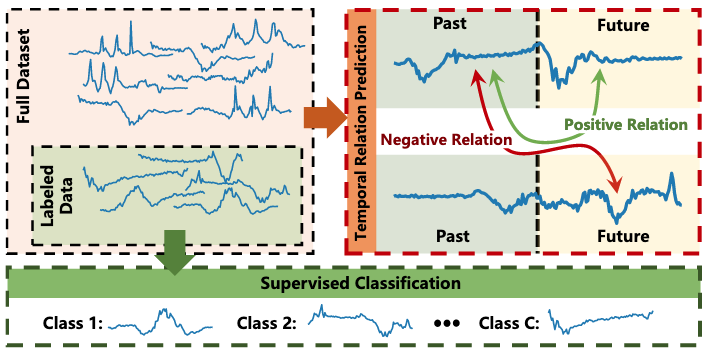  |  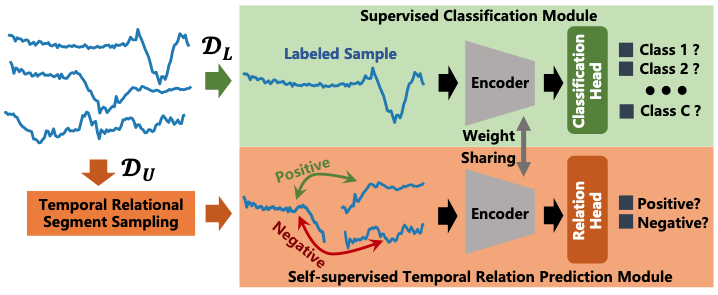  |

#### Datasets
Note: 
- the $\mathcal{D}_L$ dataset is contained in $\mathcal{D}_U $ and can be maximum equal to $\mathcal{D_U} $ (i.e. $ M \le N$).
- for supervised classificaiton part is used only $\mathcal{D}_L$
- for self-supervised classificaiton part is used the entire dataset $ \mathcal{D}_U $, also the labelled data (without taking the label).

For this project are used the following dataset:
- CricketX, UWaveGestureLibraryAll, InsectWingbeatSound: http://www.timeseriesclassification.com/dataset.php 
- XJTU bearing dataset: https://biaowang.tech/xjtu-sy-bearing-datasets/ 
- MFPT fault dataset: https://www.mfpt.org/fault-data-sets/ 
- Epilectic Seizure Recognitions: https://archive-beta.ics.uci.edu/dataset/388/epileptic+seizure+recognition 
  
and is used always the entire dataset both for supervised and semi-supervised tasks.

In [14]:
from data import dataframe, dataset

In [15]:
CricketX_train, CricketX_test, num_classes_CricketX = dataframe.load_dataframe(dataset='CricketX')
CricketX = dataset.LabelledDataset(dataframe=CricketX_test)

UWaveGestureLibraryAll_train, UWaveGestureLibraryAll_test, num_classes_UWaveGestureLibraryAll = dataframe.load_dataframe(dataset='UWaveGestureLibraryAll')
UWaveGestureLibraryAll = dataset.LabelledDataset(dataframe=UWaveGestureLibraryAll_test)

InsectWingbeatSound_train, InsectWingbeatSound_test, num_classes_InsectWingbeatSound = dataframe.load_dataframe(dataset='InsectWingbeatSound')
InsectWingbeatSound = dataset.LabelledDataset(dataframe=InsectWingbeatSound_test)

MFPT_train, MFPT_test, num_classes_MFPT = dataframe.load_dataframe(dataset='MFPT')
MFPT = dataset.LabelledDataset(dataframe=MFPT_test)

XJTU_train, XJTU_test, num_classes_XJTU = dataframe.load_dataframe(dataset='XJTU')
XJTU = dataset.LabelledDataset(dataframe=XJTU_test)

EpilepticSeizure_train, EpilepticSeizure_test, num_classes_EpilepticSeizure = dataframe.load_dataframe(dataset='EpilepticSeizure')
EpilepticSeizure = dataset.LabelledDataset(dataframe=EpilepticSeizure_test)

print(f'num_classes_CricketX:               {num_classes_CricketX}')
print(f'num_classes_UWaveGestureLibraryAll: {num_classes_UWaveGestureLibraryAll}')
print(f'num_classes_InsectWingbeatSound:    {num_classes_InsectWingbeatSound}')
print(f'num_classes_MFPT:                   {num_classes_MFPT}')
print(f'num_classes_XJTU:                   {num_classes_XJTU}')
print(f'num_classes_EpilepticSeizure:       {num_classes_EpilepticSeizure}')

num_classes_CricketX:               12
num_classes_UWaveGestureLibraryAll: 8
num_classes_InsectWingbeatSound:    11
num_classes_MFPT:                   15
num_classes_XJTU:                   15
num_classes_EpilepticSeizure:       5


### Results

In [17]:
import torch
from models import backboneEncoder, classificationHead
from test import test

from torch.nn import CrossEntropyLoss

crossEntropy = CrossEntropyLoss()

#### CricketX

------------------------------
Dataset: CricketX
------------------------------
Test of supervised models
Loss: 2.281
Accuracy: 39.744%



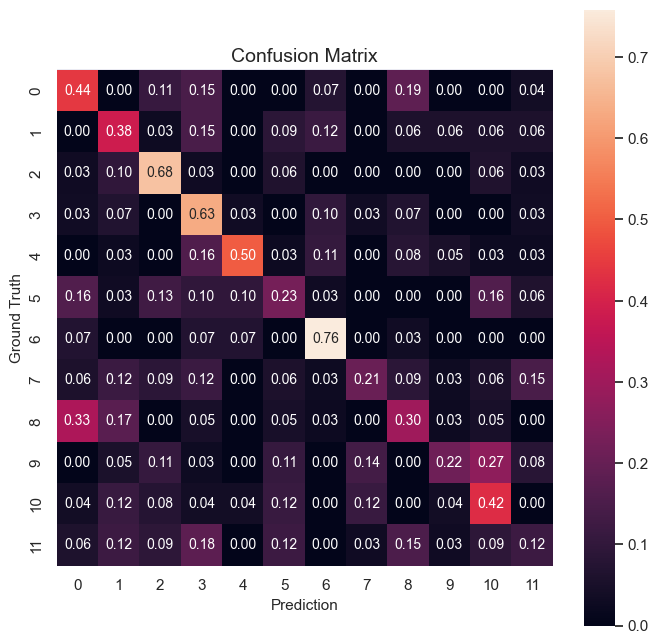

------------------------------
Test of semi-supervised models
Loss: 2.049
Accuracy: 37.179%



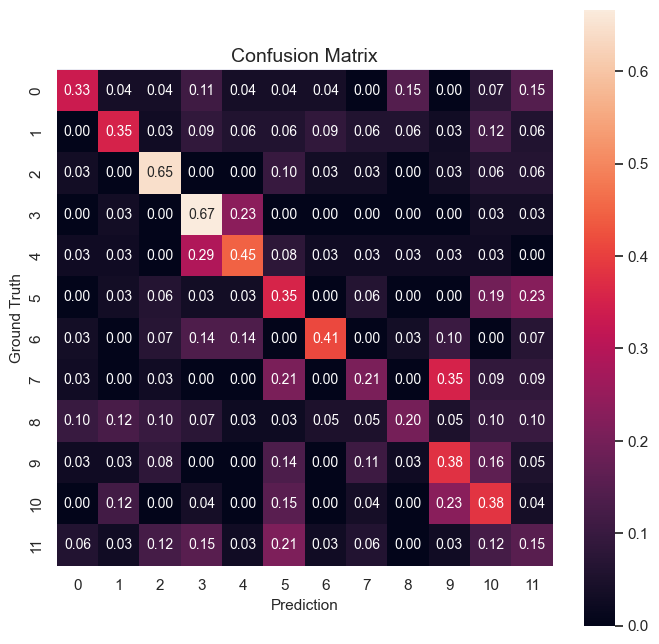

In [20]:
print('------------------------------')
print('Dataset: CricketX')

# supervised models
backbone_CricketX_s = backboneEncoder.BackboneEncoder(num_features=64)
backbone_CricketX_s.load_state_dict(torch.load('checkpoints/supervised/CricketX/CricketX_backbone.pt'))

clf_head_CricketX_s = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_CricketX)
clf_head_CricketX_s.load_state_dict(torch.load('checkpoints/supervised/CricketX/CricketX_classification_head.pt'))

# semi-supervised models
backbone_CricketX_ss = backboneEncoder.BackboneEncoder(num_features=64)
backbone_CricketX_ss.load_state_dict(torch.load('checkpoints/semi-supervised/CricketX/CricketX_backbone.pt'))

clf_head_CricketX_ss = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_CricketX)
clf_head_CricketX_ss.load_state_dict(torch.load('checkpoints/semi-supervised/CricketX/CricketX_classification_head.pt'))

# test of supervised models
print('------------------------------')
print('Test of supervised models')
test.test(dataset=CricketX, num_classes=num_classes_CricketX, 
          backboneEncoder=backbone_CricketX_s, classificationHead=clf_head_CricketX_s, crossEntropy=crossEntropy, scores=None, device='cpu')

# test of semi-supervised models
print('------------------------------')
print('Test of semi-supervised models')
test.test(dataset=CricketX, num_classes=num_classes_CricketX, 
          backboneEncoder=backbone_CricketX_ss, classificationHead=clf_head_CricketX_ss, crossEntropy=crossEntropy, scores=None, device='cpu')

#### UWaveGestureLibraryAll

In [ ]:
print('------------------------------')
print('Dataset: UWaveGestureLibraryAll')

# supervised models
backbone_UWaveGestureLibraryAll_s = backboneEncoder.BackboneEncoder(num_features=64)
backbone_UWaveGestureLibraryAll_s.load_state_dict(torch.load('checkpoints/supervised/UWaveGestureLibraryAll/UWaveGestureLibraryAll_backbone.pt'))

clf_head_UWaveGestureLibraryAll_s = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_UWaveGestureLibraryAll)
clf_head_UWaveGestureLibraryAll_s.load_state_dict(torch.load('checkpoints/supervised/UWaveGestureLibraryAll/UWaveGestureLibraryAll_classification_head.pt'))

# semi-supervised models
backbone_UWaveGestureLibraryAll_ss = backboneEncoder.BackboneEncoder(num_features=64)
backbone_UWaveGestureLibraryAll_ss.load_state_dict(torch.load('checkpoints/semi-supervised/UWaveGestureLibraryAll/UWaveGestureLibraryAll_backbone.pt'))

clf_head_UWaveGestureLibraryAll_ss = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_UWaveGestureLibraryAll)
clf_head_UWaveGestureLibraryAll_ss.load_state_dict(torch.load('checkpoints/semi-supervised/UWaveGestureLibraryAll/UWaveGestureLibraryAll_classification_head.pt'))

# test of supervised models
print('------------------------------')
print('Test of supervised models')
test.test(dataset=UWaveGestureLibraryAll, num_classes=num_classes_UWaveGestureLibraryAll, 
          backboneEncoder=backbone_UWaveGestureLibraryAll_s, classificationHead=clf_head_UWaveGestureLibraryAll_s, crossEntropy=crossEntropy, scores=None, device='cpu')

# test of semi-supervised models
print('------------------------------')
print('Test of semi-supervised models')
test.test(dataset=UWaveGestureLibraryAll, num_classes=num_classes_UWaveGestureLibraryAll, 
          backboneEncoder=backbone_UWaveGestureLibraryAll_ss, classificationHead=clf_head_UWaveGestureLibraryAll_ss, crossEntropy=crossEntropy, scores=None, device='cpu')

#### InsectiWingbeatSound

In [ ]:
print('------------------------------')
print('Dataset: InsectWingbeatSound')

# supervised models
backbone_InsectWingbeatSound_s = backboneEncoder.BackboneEncoder(num_features=64)
backbone_InsectWingbeatSound_s.load_state_dict(torch.load('checkpoints/supervised/InsectWingbeatSound/InsectWingbeatSound_backbone.pt'))

clf_head_InsectWingbeatSound_s = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_InsectWingbeatSound)
clf_head_InsectWingbeatSound_s.load_state_dict(torch.load('checkpoints/supervised/InsectWingbeatSound/InsectWingbeatSound_classification_head.pt'))

# semi-supervised models
backbone_InsectWingbeatSound_ss = backboneEncoder.BackboneEncoder(num_features=64)
backbone_InsectWingbeatSound_ss.load_state_dict(torch.load('checkpoints/semi-supervised/InsectWingbeatSound/InsectWingbeatSound_backbone.pt'))

clf_head_InsectWingbeatSound_ss = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_InsectWingbeatSound)
clf_head_InsectWingbeatSound_ss.load_state_dict(torch.load('checkpoints/semi-supervised/InsectWingbeatSound/InsectWingbeatSound_classification_head.pt'))

# test of supervised models
print('------------------------------')
print('Test of supervised models')
test.test(dataset=InsectWingbeatSound, num_classes=num_classes_InsectWingbeatSound, 
          backboneEncoder=backbone_InsectWingbeatSound_s, classificationHead=clf_head_InsectWingbeatSound_s, crossEntropy=crossEntropy, scores=None, device='cpu')

# test of semi-supervised models
print('------------------------------')
print('Test of semi-supervised models')
test.test(dataset=InsectWingbeatSound, num_classes=num_classes_InsectWingbeatSound, 
          backboneEncoder=backbone_InsectWingbeatSound_ss, classificationHead=clf_head_InsectWingbeatSound_ss, crossEntropy=crossEntropy, scores=None, device='cpu')

#### MFPT

In [ ]:
print('------------------------------')
print('Dataset: MFPT')

# supervised models
backbone_MFPT_s = backboneEncoder.BackboneEncoder(num_features=64)
backbone_MFPT_s.load_state_dict(torch.load('checkpoints/supervised/MFPT/MFPT_backbone.pt'))

clf_head_MFPT_s = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_MFPT)
clf_head_MFPT_s.load_state_dict(torch.load('checkpoints/supervised/MFPT/MFPT_classification_head.pt'))

# semi-supervised models
backbone_MFPT_ss = backboneEncoder.BackboneEncoder(num_features=64)
backbone_MFPT_ss.load_state_dict(torch.load('checkpoints/semi-supervised/MFPT/MFPT_backbone.pt'))

clf_head_MFPT_ss = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_MFPT)
clf_head_MFPT_ss.load_state_dict(torch.load('checkpoints/semi-supervised/MFPT/MFPT_classification_head.pt'))

# test of supervised models
print('------------------------------')
print('Test of supervised models')
test.test(dataset=MFPT, num_classes=num_classes_MFPT, 
          backboneEncoder=backbone_MFPT_s, classificationHead=clf_head_MFPT_s, crossEntropy=crossEntropy, scores=None, device='cpu')

# test of semi-supervised models
print('------------------------------')
print('Test of semi-supervised models')
test.test(dataset=MFPT, num_classes=num_classes_MFPT, 
          backboneEncoder=backbone_MFPT_ss, classificationHead=clf_head_MFPT_ss, crossEntropy=crossEntropy, scores=None, device='cpu')

#### XJTU

In [ ]:
print('------------------------------')
print('Dataset: XJTU')

# supervised models
backbone_XJTU_s = backboneEncoder.BackboneEncoder(num_features=64)
backbone_XJTU_s.load_state_dict(torch.load('checkpoints/supervised/XJTU/XJTU_backbone.pt'))

clf_head_XJTU_s = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_XJTU)
clf_head_XJTU_s.load_state_dict(torch.load('checkpoints/supervised/XJTU/XJTU_classification_head.pt'))

# semi-supervised models
backbone_XJTU_ss = backboneEncoder.BackboneEncoder(num_features=64)
backbone_XJTU_ss.load_state_dict(torch.load('checkpoints/semi-supervised/XJTU/XJTU_backbone.pt'))

clf_head_XJTU_ss = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_XJTU)
clf_head_XJTU_ss.load_state_dict(torch.load('checkpoints/semi-supervised/XJTU/XJTU_classification_head.pt'))

# test of supervised models
print('------------------------------')
print('Test of supervised models')
test.test(dataset=XJTU, num_classes=num_classes_XJTU, 
          backboneEncoder=backbone_XJTU_s, classificationHead=clf_head_XJTU_s, crossEntropy=crossEntropy, scores=None, device='cpu')

# test of semi-supervised models
print('------------------------------')
print('Test of semi-supervised models')
test.test(dataset=XJTU, num_classes=num_classes_XJTU, 
          backboneEncoder=backbone_XJTU_ss, classificationHead=clf_head_XJTU_ss, crossEntropy=crossEntropy, scores=None, device='cpu')

#### EpilepticSeizure

In [ ]:
print('------------------------------')
print('Dataset: EpilepticSeizure')

# supervised models
backbone_EpilepticSeizure_s = backboneEncoder.BackboneEncoder(num_features=64)
backbone_EpilepticSeizure_s.load_state_dict(torch.load('checkpoints/supervised/EpilepticSeizure/EpilepticSeizure_backbone.pt'))

clf_head_EpilepticSeizure_s = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_EpilepticSeizure)
clf_head_EpilepticSeizure_s.load_state_dict(torch.load('checkpoints/supervised/EpilepticSeizure/EpilepticSeizure_classification_head.pt'))

# semi-supervised models
backbone_EpilepticSeizure_ss = backboneEncoder.BackboneEncoder(num_features=64)
backbone_EpilepticSeizure_ss.load_state_dict(torch.load('checkpoints/semi-supervised/EpilepticSeizure/EpilepticSeizure_backbone.pt'))

clf_head_EpilepticSeizure_ss = classificationHead.ClassificationHead(num_features=64, num_classes=num_classes_EpilepticSeizure)
clf_head_EpilepticSeizure_ss.load_state_dict(torch.load('checkpoints/semi-supervised/EpilepticSeizure/EpilepticSeizure_classification_head.pt'))

# test of supervised models
print('------------------------------')
print('Test of supervised models')
test.test(dataset=EpilepticSeizure, num_classes=num_classes_EpilepticSeizure, 
          backboneEncoder=backbone_EpilepticSeizure_s, classificationHead=clf_head_EpilepticSeizure_s, crossEntropy=crossEntropy, scores=None, device='cpu')

# test of semi-supervised models
print('------------------------------')
print('Test of semi-supervised models')
test.test(dataset=EpilepticSeizure, num_classes=num_classes_EpilepticSeizure, 
          backboneEncoder=backbone_EpilepticSeizure_ss, classificationHead=clf_head_EpilepticSeizure_ss, crossEntropy=crossEntropy, scores=None, device='cpu')